# 🌍 WorldSim — Adaptive Resource Scarcity & Agent Strategy Simulator

**A multi-agent reinforcement learning simulation** where autonomous AI agents govern distinct regions, each with finite resources (water, food, energy, land). Agents learn survival, growth, and negotiation strategies through Q-learning — with **no pre-programmed rules**.

### Key Features
- **8 unique biome-based regions** with distinct resource profiles
- **Q-learning agents** that autonomously discover strategies
- **Climate event system** with seasonal cycles and long-term climate stress
- **Bilateral trade system** with evolving inter-region relationships
- **Population dynamics** driven by resource satisfaction
- **Rich visualizations** of the evolving world state
- **Sustainability analysis** revealing emergent real-world insights

---

## 1. Setup & Dependencies

In [1]:
# Install required packages (run once)
import subprocess, sys
packages = ["numpy", "pandas", "matplotlib", "plotly", "networkx"]
for pkg in packages:
    try:
        __import__(pkg)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg, "-q"])
        print(f"Installed {pkg}")
print("✓ All dependencies ready")

✓ All dependencies ready


In [2]:
# Core imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import time
import warnings
warnings.filterwarnings('ignore')

# WorldSim modules (same directory)
from worldsim_engine import World, RESOURCE_KEYS, SEASONS, EventType, BiomeType
from worldsim_agents import AgentManager, QLearningAgent, ACTIONS, ACTION_DESCRIPTIONS, compute_reward
from worldsim_viz import (
    plot_world_map, plot_resource_timeseries, plot_population,
    plot_trade_network, plot_strategy_evolution, plot_happiness_tech,
    plot_event_timeline, plot_trade_volume, plot_reward_curves,
    plot_strategy_heatmap, plot_relationship_matrix,
    plotly_resource_dashboard, plot_sustainability_analysis,
    plot_climate_stress, print_summary_table,
    REGION_COLORS, RESOURCE_COLORS, BIOME_ICONS
)

# Jupyter display settings
%matplotlib inline
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

print("✓ WorldSim modules loaded successfully")

✓ WorldSim modules loaded successfully


---
## 2. World Initialization

We create a world with **8 distinct regions**, each based on a real-world biome type with unique resource endowments, production rates, and population dynamics. The geographic layout determines neighbour relationships and trade connectivity.

In [3]:
# Configuration
SEED = 42
NUM_CYCLES = 500      # Total simulation cycles
PRINT_EVERY = 100     # Print progress every N cycles

# Initialize the world
world = World(seed=SEED, num_cycles=NUM_CYCLES)

# Initialize AI agents — one Q-learning agent per region
agent_manager = AgentManager(world.get_region_names(), seed=SEED)

print(f"World created with {len(world.regions)} regions:")
print(f"{'='*75}")
for name, region in world.regions.items():
    icon = BIOME_ICONS.get(region.biome.value, '🌍')
    print(f"  {icon} {name:<14} | Biome: {region.biome.value:<22} | Pop: {region.population:>4.0f} | "
          f"Neighbors: {', '.join(region.neighbors)}")
print(f"{'='*75}")

World created with 8 regions:
  🌴 Verdantia      | Biome: Tropical Rainforest    | Pop:  120 | Neighbors: Temperalis, Aridia, Maritosa
  🏜️ Aridia         | Biome: Arid Desert            | Pop:   80 | Neighbors: Borealis, Verdantia, Montarok
  🌾 Temperalis     | Biome: Temperate Plains       | Pop:  150 | Neighbors: Fluviana, Maritosa, Verdantia
  🌲 Borealis       | Biome: Continental Forest     | Pop:  100 | Neighbors: Montarok, Temperalis, Fluviana
  ❄️ Glaciera       | Biome: Polar Tundra           | Pop:   50 | Neighbors: Fluviana, Borealis, Montarok
  🌊 Maritosa       | Biome: Coastal Maritime       | Pop:  130 | Neighbors: Temperalis, Fluviana, Verdantia
  ⛰️ Montarok       | Biome: Highland Mountains     | Pop:   70 | Neighbors: Borealis, Aridia, Glaciera
  🏞️ Fluviana       | Biome: River Delta            | Pop:  140 | Neighbors: Temperalis, Glaciera, Borealis


In [4]:
# Display initial resource endowments
init_data = {}
for name, region in world.regions.items():
    init_data[name] = {
        'Biome': region.biome.value,
        'Population': region.population,
        'Water': f"{region.resources['water']:.0f}/{region.max_resources['water']:.0f}",
        'Food': f"{region.resources['food']:.0f}/{region.max_resources['food']:.0f}",
        'Energy': f"{region.resources['energy']:.0f}/{region.max_resources['energy']:.0f}",
        'Land': f"{region.resources['land']:.0f}/{region.max_resources['land']:.0f}",
    }

df_init = pd.DataFrame(init_data).T
df_init.index.name = 'Region'
print("\n📊 Initial Resource State:")
print(df_init.to_string())


📊 Initial Resource State:
                          Biome Population     Water      Food    Energy      Land
Region                                                                            
Verdantia   Tropical Rainforest        120  800/1000  700/1000   300/600   500/600
Aridia              Arid Desert         80   200/500   300/600  800/1000   700/900
Temperalis     Temperate Plains        150   600/800   600/800   500/700   600/800
Borealis     Continental Forest        100   500/700   400/700   600/800  800/1000
Glaciera           Polar Tundra         50  900/1200   150/400   200/500   300/400
Maritosa       Coastal Maritime        130   700/900   600/800   400/600   350/450
Montarok     Highland Mountains         70   400/600   250/500   700/900   400/500
Fluviana            River Delta        140  850/1100   750/900   350/500   550/700


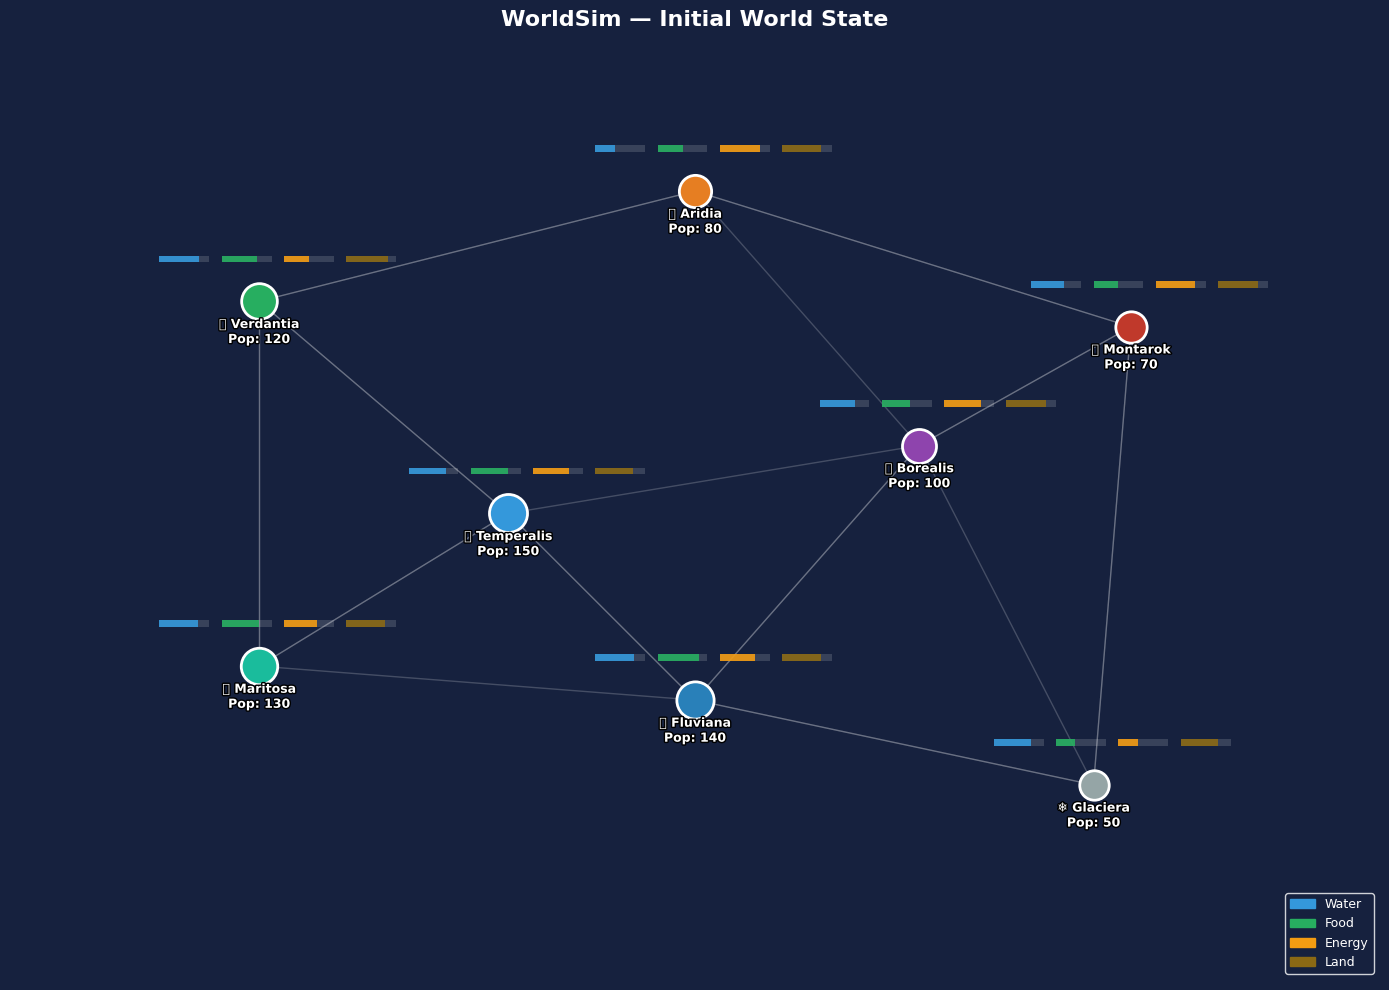

In [5]:
# Visualize the initial world map
fig = plot_world_map(world, title="WorldSim — Initial World State")
plt.show()

---
## 3. Simulation Engine

### How the Simulation Works (Each Cycle)

1. **Natural Production** — Each region produces resources based on biome, tech level, and land availability
2. **Population Consumption** — Resources consumed proportional to population size
3. **Agent Action** — Q-learning agent selects and executes a strategic action
4. **Climate Events** — Random events (droughts, floods, harvests) alter the landscape
5. **Trade Negotiation** — Agents with surplus trade with deficit regions
6. **Population Dynamics** — Growth/decline based on satisfaction; collapse if population < 5
7. **Learning Update** — Agent receives reward signal and updates Q-table

### Agent Action Space
| Action | Description |
|--------|-------------|
| `focus_water` | Prioritise water production |
| `focus_food` | Prioritise food production |
| `focus_energy` | Prioritise energy production |
| `expand_land` | Develop & reclaim land |
| `conserve` | Ration resources to reduce consumption |
| `trade` | Negotiate bilateral trades with neighbours |
| `research` | Invest in technology advancement |
| `stockpile` | Build reserves & expand storage |
| `balance` | Balanced moderate approach |

In [6]:
# ══════════════════════════════════════════════════════════
# MAIN SIMULATION LOOP
# ══════════════════════════════════════════════════════════

start_time = time.time()
print(f"🚀 Starting simulation: {NUM_CYCLES} cycles, {len(world.regions)} regions, {len(ACTIONS)} actions\n")

for cycle in range(NUM_CYCLES):
    # 1. Save pre-step state for reward computation
    prev_snap = agent_manager.snapshot_states(world)
    
    # 2. Agents choose actions based on current state
    decisions = agent_manager.get_decisions(world)
    
    # 3. World evolves one step
    cycle_log = world.step(decisions)
    
    # 4. Agents learn from outcomes
    agent_manager.update_all(world, prev_snap)
    
    # 5. Progress reporting
    if (cycle + 1) % PRINT_EVERY == 0:
        alive = sum(1 for r in world.regions.values() if r.is_alive)
        total_pop = sum(r.population for r in world.regions.values() if r.is_alive)
        trades = world.trade_count_history[-1] if world.trade_count_history else 0
        events = len(cycle_log['events'])
        eps = np.mean([a.epsilon for a in agent_manager.agents.values()])
        print(f"  Cycle {cycle+1:>4}/{NUM_CYCLES} | Season: {cycle_log['season']:<8} | "
              f"Alive: {alive}/8 | Pop: {total_pop:>6.0f} | "
              f"Trades: {trades} | Events: {events} | ε: {eps:.3f}")
    
    # Report collapses immediately
    for collapsed in cycle_log['collapses']:
        print(f"  ⚠️  CYCLE {cycle+1}: {collapsed} has COLLAPSED! ☠️")

elapsed = time.time() - start_time
print(f"\n✅ Simulation complete in {elapsed:.1f}s")
print(f"   {world.cycle} cycles | {len(world.event_history)} events | "
      f"{len(world.trade_system.trade_history)} trades executed")

🚀 Starting simulation: 500 cycles, 8 regions, 9 actions

  Cycle  100/500 | Season: Winter   | Alive: 8/8 | Pop:    999 | Trades: 0 | Events: 3 | ε: 0.548
  Cycle  200/500 | Season: Winter   | Alive: 8/8 | Pop:   1108 | Trades: 1 | Events: 1 | ε: 0.300
  Cycle  300/500 | Season: Winter   | Alive: 8/8 | Pop:   1201 | Trades: 1 | Events: 4 | ε: 0.164
  Cycle  400/500 | Season: Winter   | Alive: 8/8 | Pop:   1079 | Trades: 0 | Events: 3 | ε: 0.090
  Cycle  500/500 | Season: Winter   | Alive: 8/8 | Pop:    943 | Trades: 0 | Events: 2 | ε: 0.050

✅ Simulation complete in 0.4s
   500 cycles | 1460 events | 342 trades executed


In [7]:
# Final state summary table
print_summary_table(world, agent_manager)


                                   WORLDSIM FINAL STATE                                   
                                        Cycle 500                                         
Region         Status      Pop   Water    Food  Energy    Land  Happy  Tech Strategy       
------------------------------------------------------------------------------------------
Verdantia      ✓ Alive     155    1024    1053     365     528   0.79  3.00 conserve       
Aridia         ✓ Alive      78     109     428    1076     898   0.73  2.66 balance        
Temperalis     ✓ Alive     192     168     867     764     781   0.80  3.00 research       
Borealis       ✓ Alive      93     181     909     389     889   0.65  3.00 focus_water    
Glaciera       ✓ Alive      61    1385     263     110     221   0.60  3.00 focus_water    
Maritosa       ✓ Alive      97    1827    1624    1231     270   0.87  2.43 focus_energy   
Montarok       ✓ Alive      24     357     562    1137     284   0.74  2.72 focus_

---
## 4. World Evolution — Resource Dynamics

How did each resource evolve across all regions? Which regions maintained stability, and which faced crises?

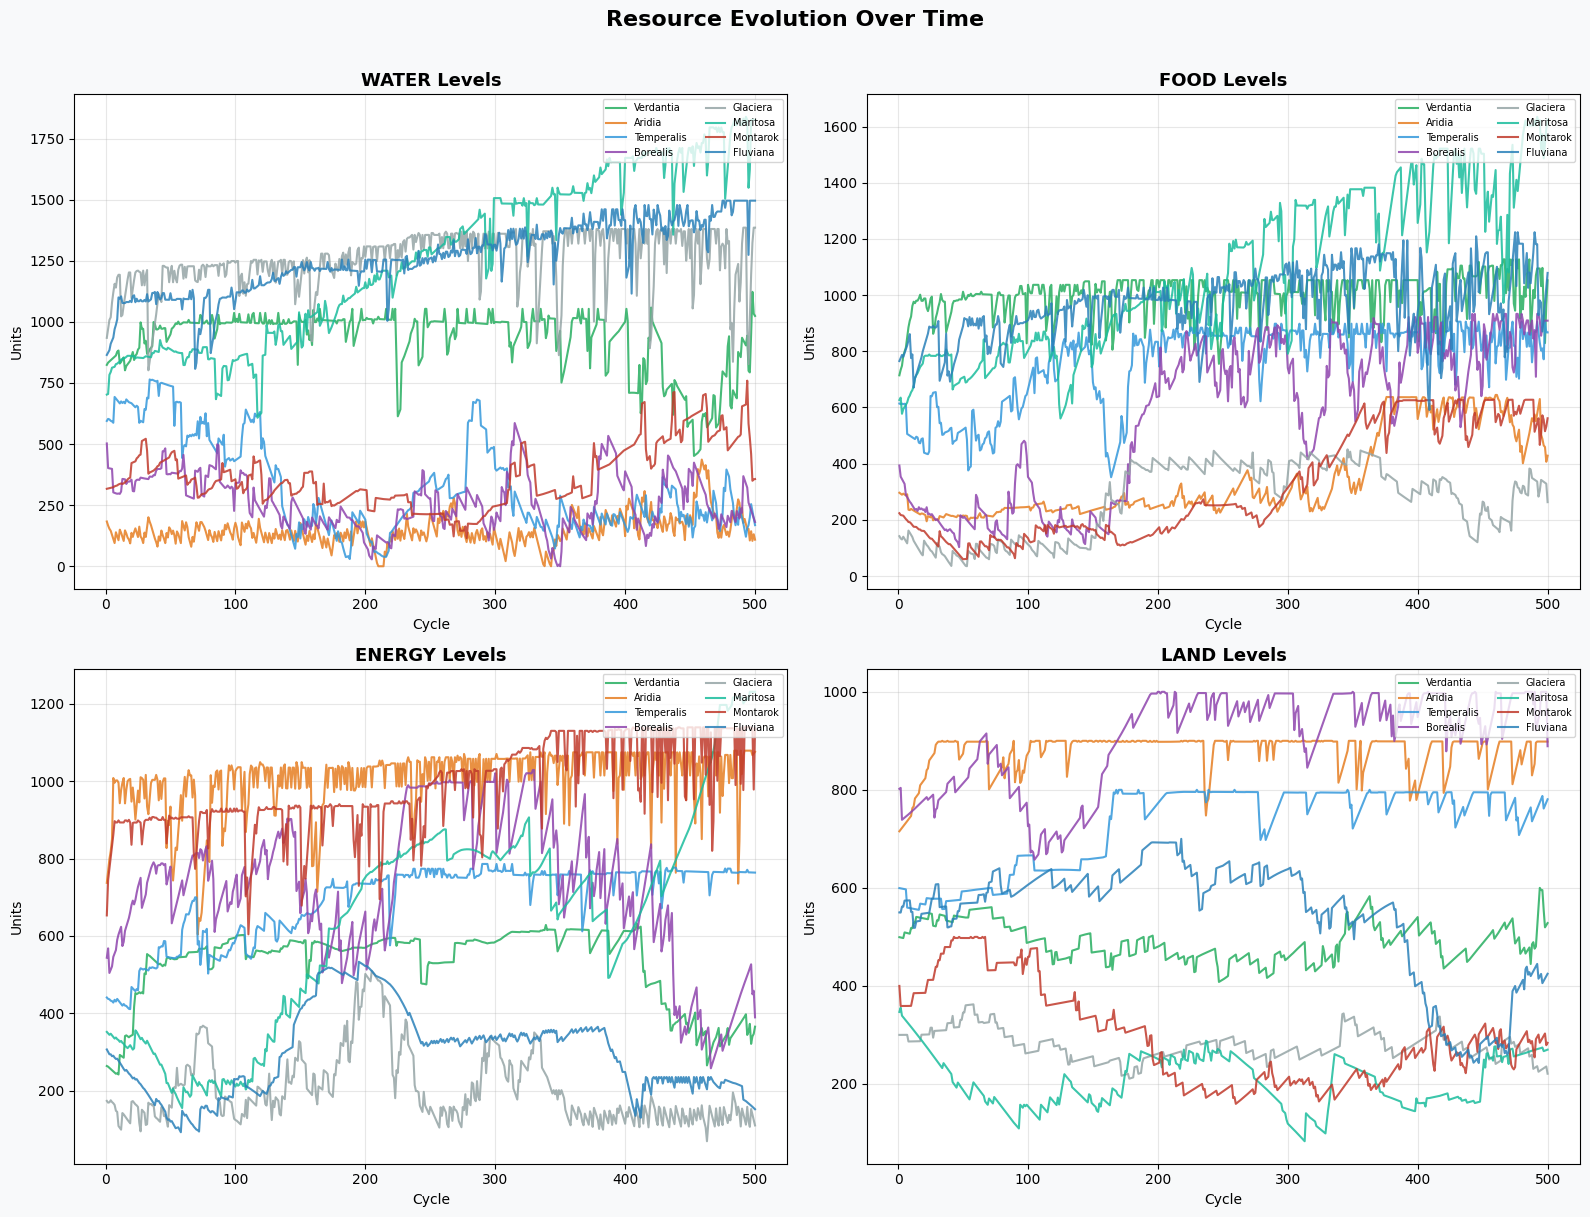

In [8]:
fig = plot_resource_timeseries(world)
plt.show()

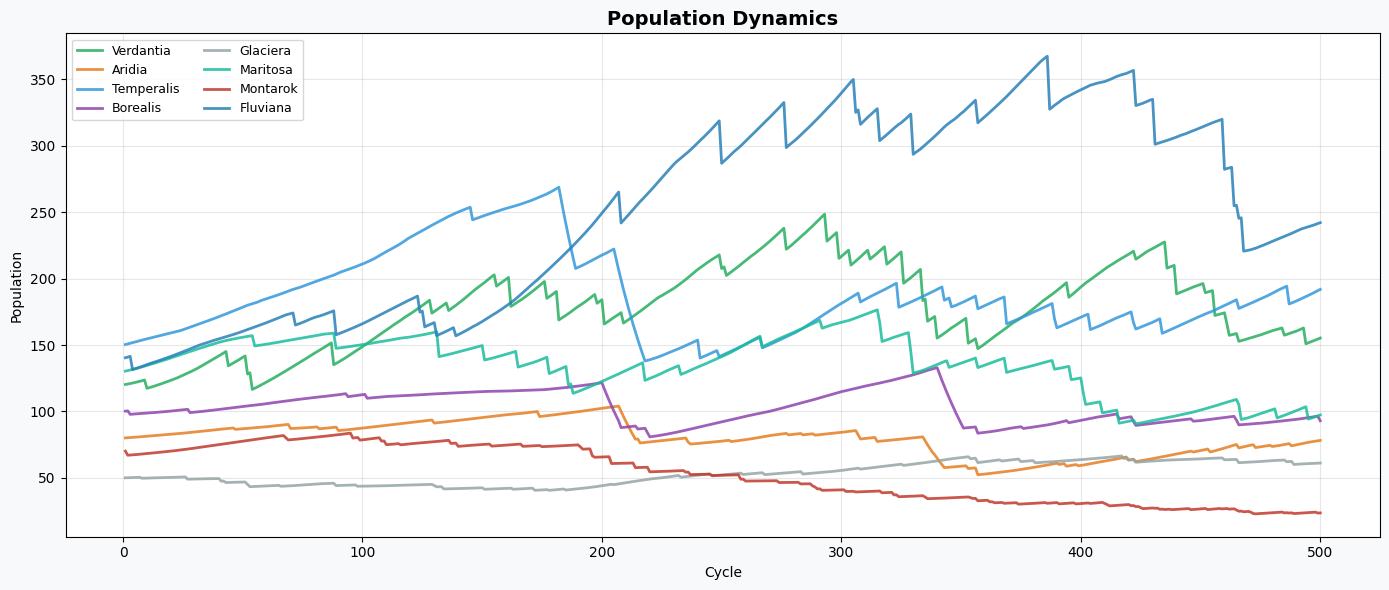

In [9]:
fig = plot_population(world)
plt.show()

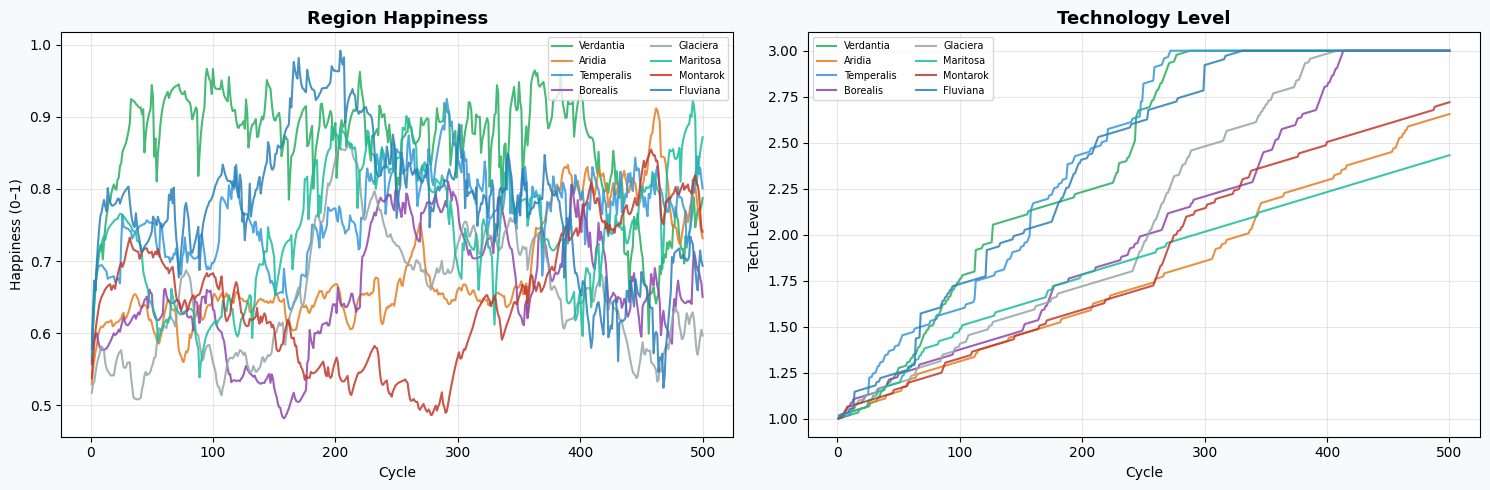

In [10]:
fig = plot_happiness_tech(world)
plt.show()

---
## 5. Climate Events & World Shocks

Climate events introduce **stochastic disruptions** — droughts, floods, plagues, energy crises — with increasing frequency as climate stress accumulates over time. Positive events (bumper harvests, tech leaps) also occur.

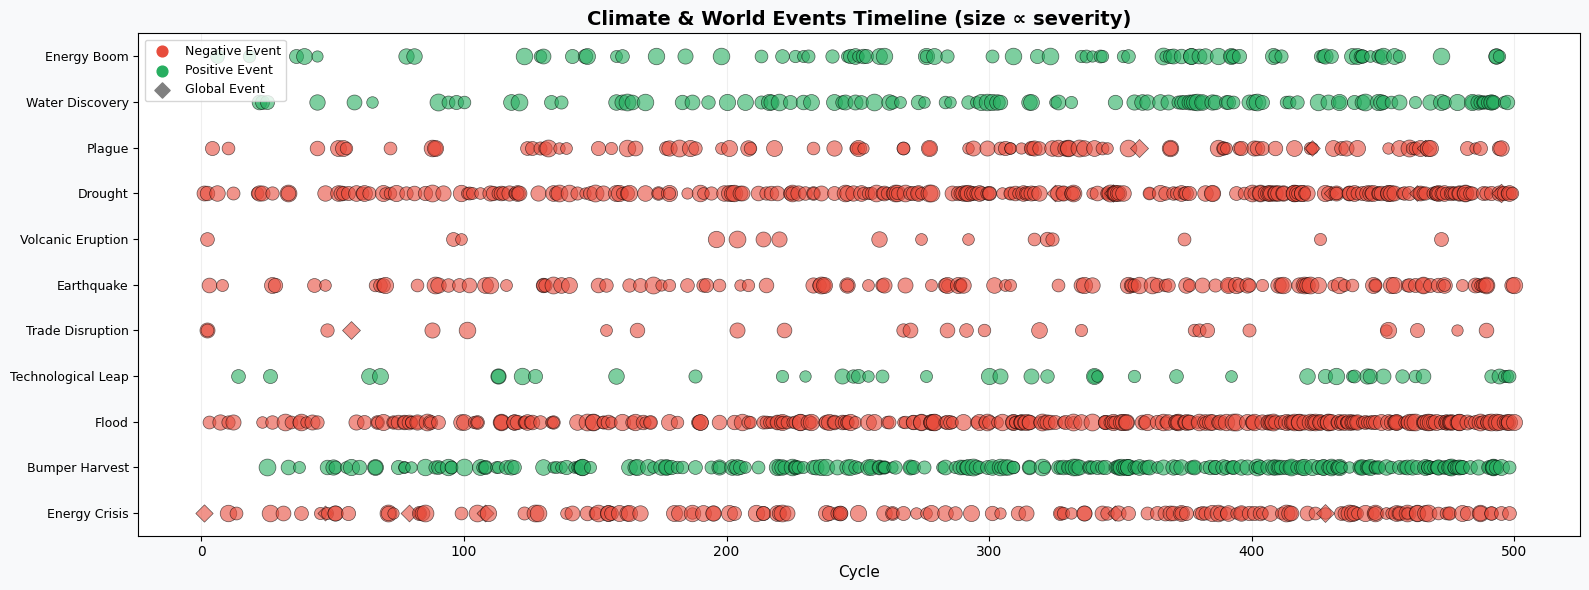

In [11]:
fig = plot_event_timeline(world)
plt.show()

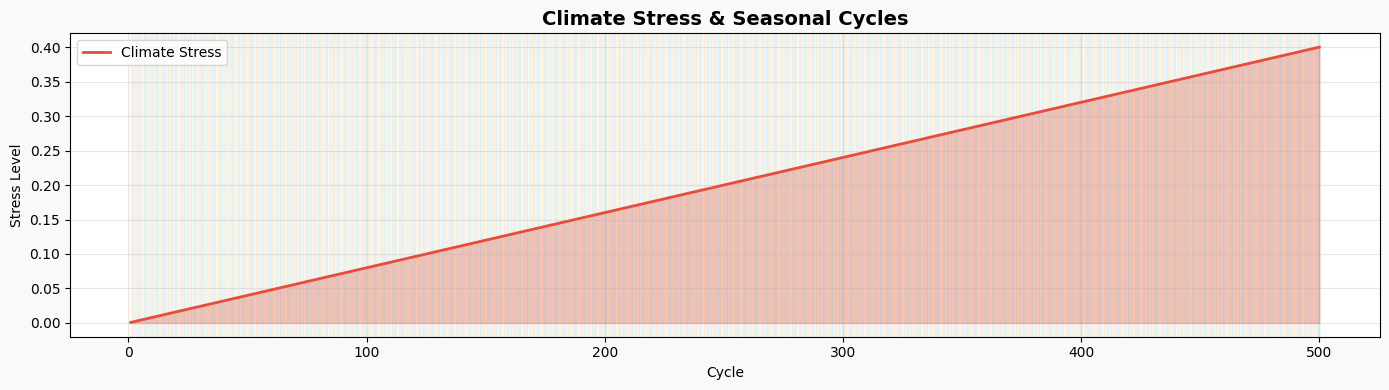

In [12]:
fig = plot_climate_stress(world)
plt.show()

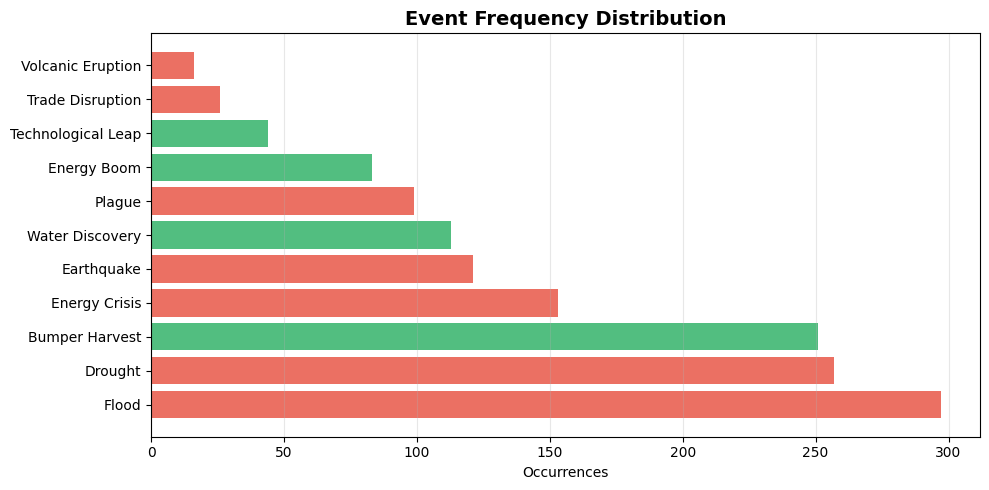


Total events: 1460
Global events: 15
Average severity: 0.64


In [13]:
# Event frequency analysis
event_counts = {}
for evt in world.event_history:
    etype = evt['type'].value if hasattr(evt['type'], 'value') else str(evt['type'])
    event_counts[etype] = event_counts.get(etype, 0) + 1

event_df = pd.DataFrame([
    {'Event Type': k.replace('_', ' ').title(), 'Count': v}
    for k, v in sorted(event_counts.items(), key=lambda x: -x[1])
])

fig, ax = plt.subplots(figsize=(10, 5))
positive = {'Bumper Harvest', 'Energy Boom', 'Water Discovery', 'Technological Leap'}
colors = ['#27ae60' if e in positive else '#e74c3c' for e in event_df['Event Type']]
ax.barh(event_df['Event Type'], event_df['Count'], color=colors, alpha=0.8)
ax.set_xlabel('Occurrences')
ax.set_title('Event Frequency Distribution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\nTotal events: {len(world.event_history)}")
print(f"Global events: {sum(1 for e in world.event_history if e.get('is_global'))}")
print(f"Average severity: {np.mean([e['severity'] for e in world.event_history]):.2f}")

---
## 6. Trade Networks & Diplomacy

Regions with complementary resource profiles can form trade relationships. The trade system uses **relationship scores** that evolve based on successful trades and decay without interaction.

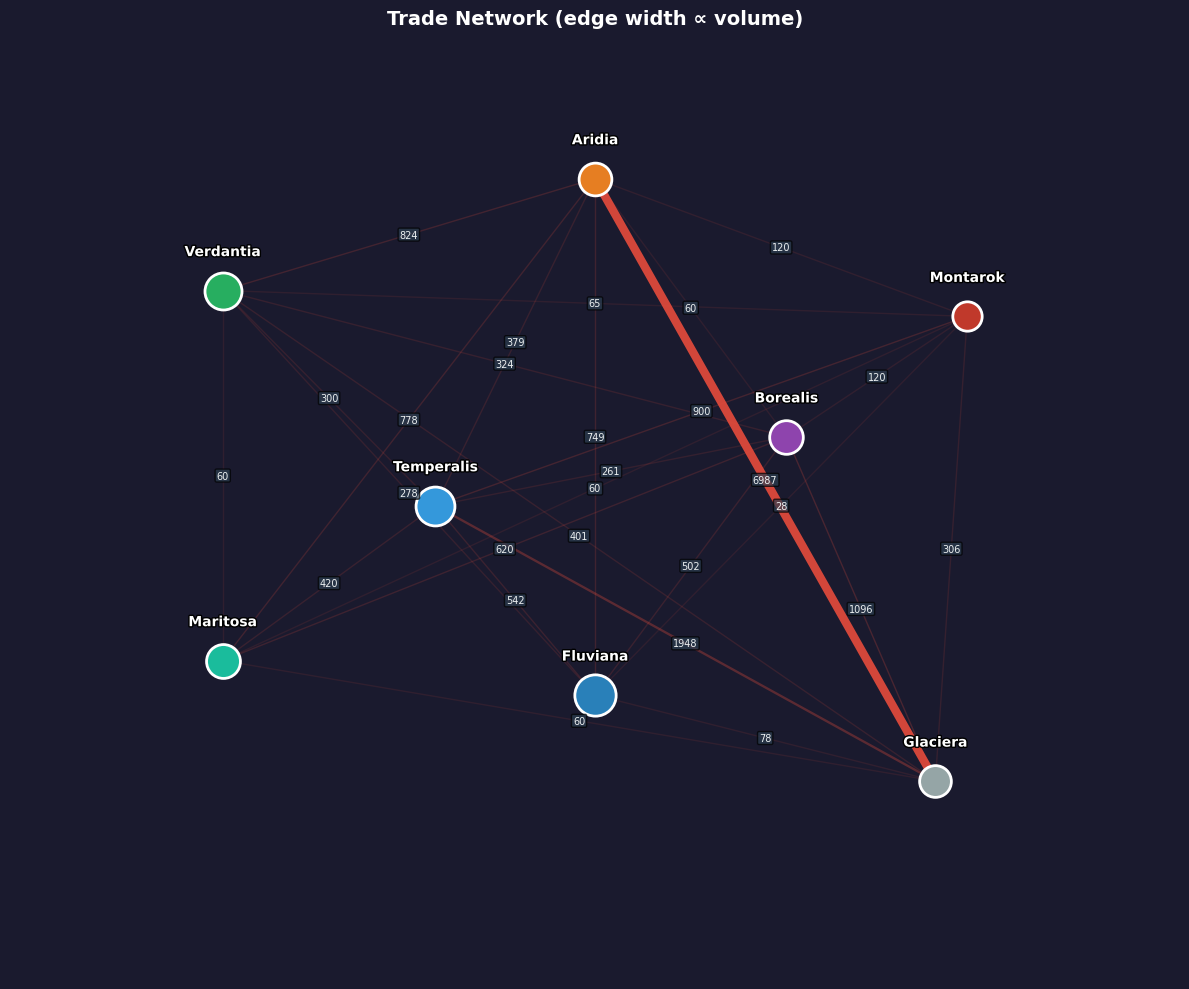

In [14]:
fig = plot_trade_network(world)
if fig:
    plt.show()

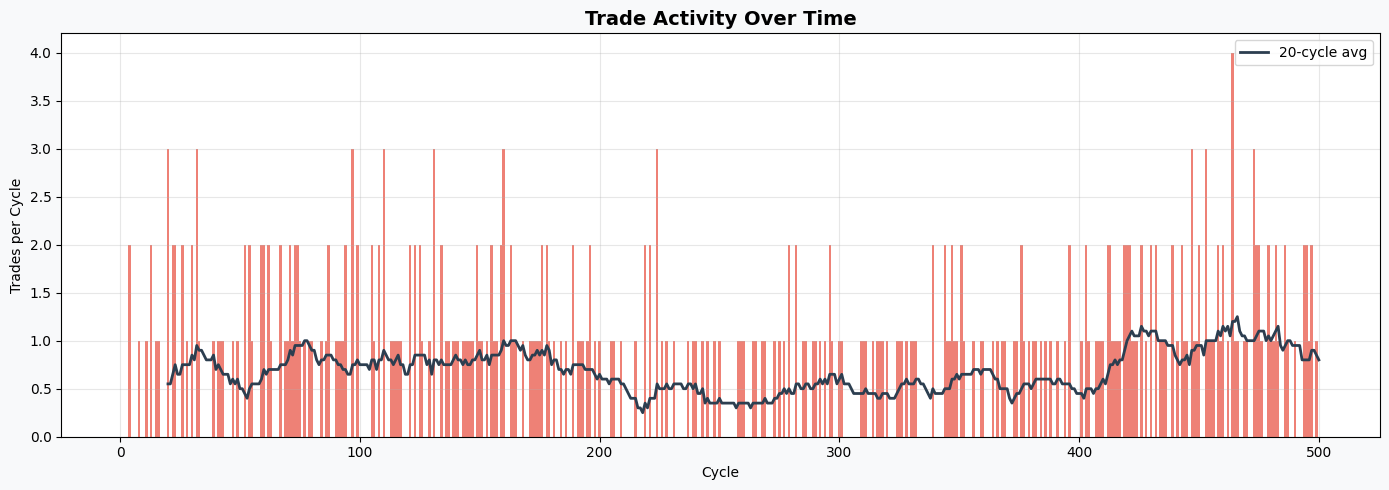

In [15]:
fig = plot_trade_volume(world)
plt.show()

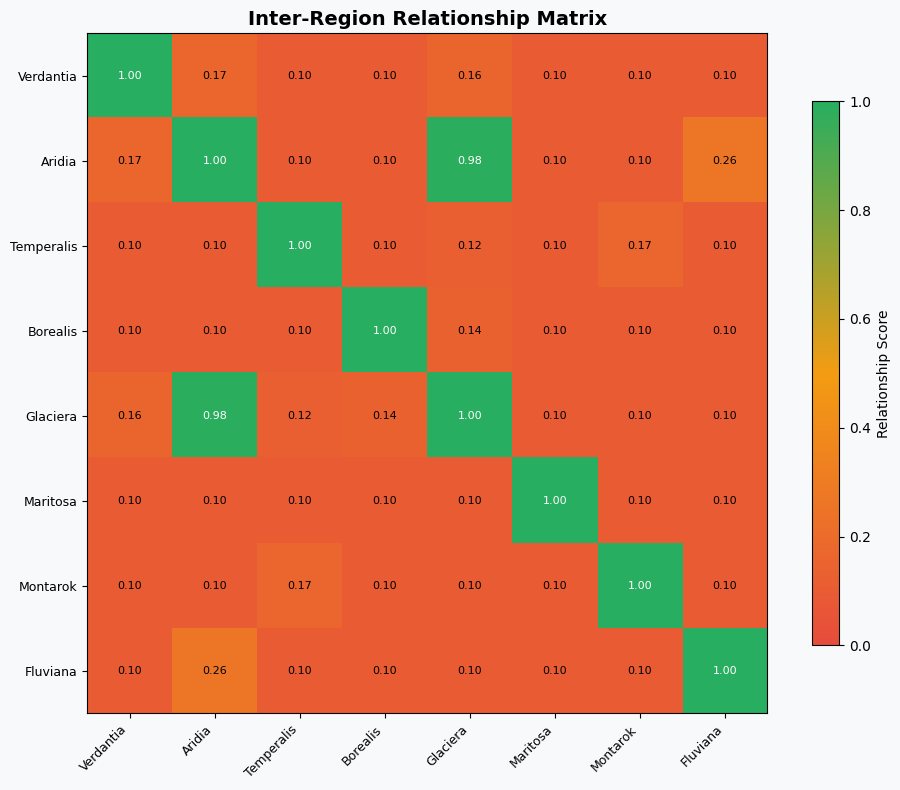

In [16]:
fig = plot_relationship_matrix(world)
plt.show()

In [17]:
# Trade partner analysis
trade_pairs = {}
for t in world.trade_system.trade_history:
    pair = tuple(sorted([t['buyer'], t['seller']]))
    trade_pairs[pair] = trade_pairs.get(pair, 0) + 1

print("🤝 Top Trade Partnerships:")
print(f"{'Pair':<35} {'Trades':>8} {'Relationship':>12}")
print("-" * 58)
for (r1, r2), count in sorted(trade_pairs.items(), key=lambda x: -x[1])[:10]:
    rel = world.trade_system.get_rel(r1, r2)
    bar = '█' * int(rel * 20) + '░' * (20 - int(rel * 20))
    print(f"  {r1} ↔ {r2:<14} {count:>6}     {bar} {rel:.2f}")

# Resource flow analysis
resource_flows = {}
for t in world.trade_system.trade_history:
    res = t['resource_bought']
    resource_flows[res] = resource_flows.get(res, 0) + t['amount']

print(f"\n📦 Total Resource Flows:")
for res, vol in sorted(resource_flows.items(), key=lambda x: -x[1]):
    print(f"  {res.capitalize():<10}: {vol:>8.0f} units traded")

🤝 Top Trade Partnerships:
Pair                                  Trades Relationship
----------------------------------------------------------
  Aridia ↔ Glaciera          124     ███████████████████░ 0.98
  Glaciera ↔ Temperalis         33     ██░░░░░░░░░░░░░░░░░░ 0.12
  Borealis ↔ Glaciera           19     ██░░░░░░░░░░░░░░░░░░ 0.14
  Aridia ↔ Maritosa           19     ██░░░░░░░░░░░░░░░░░░ 0.10
  Aridia ↔ Fluviana           19     █████░░░░░░░░░░░░░░░ 0.26
  Montarok ↔ Temperalis         17     ███░░░░░░░░░░░░░░░░░ 0.17
  Aridia ↔ Verdantia          15     ███░░░░░░░░░░░░░░░░░ 0.17
  Borealis ↔ Maritosa           13     ██░░░░░░░░░░░░░░░░░░ 0.10
  Fluviana ↔ Temperalis         10     ██░░░░░░░░░░░░░░░░░░ 0.10
  Borealis ↔ Fluviana            9     ██░░░░░░░░░░░░░░░░░░ 0.10

📦 Total Resource Flows:
  Water     :    11384 units traded
  Energy    :     4713 units traded
  Food      :     2010 units traded
  Land      :      160 units traded


---
## 7. Agent Strategy Analysis

Each Q-learning agent **discovers its own strategy** through trial and error. The strategy evolution shows how agents adapt their behaviour over time — shifting from exploration to exploitation of learned policies.

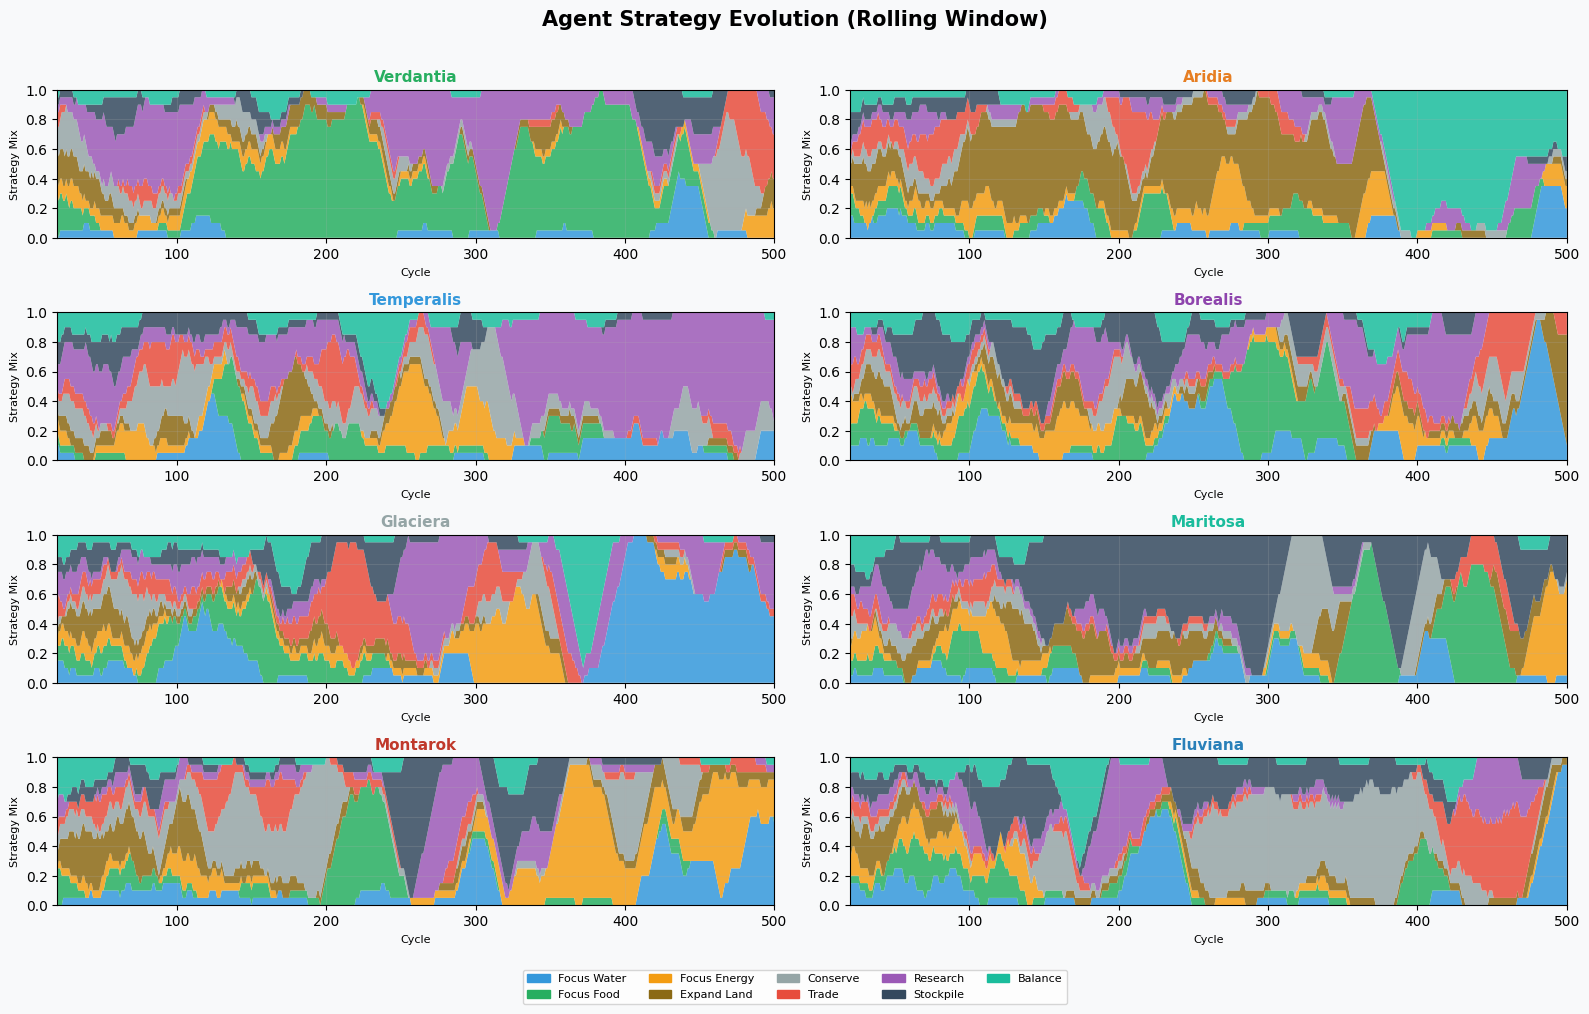

In [18]:
fig = plot_strategy_evolution(agent_manager, world)
plt.show()

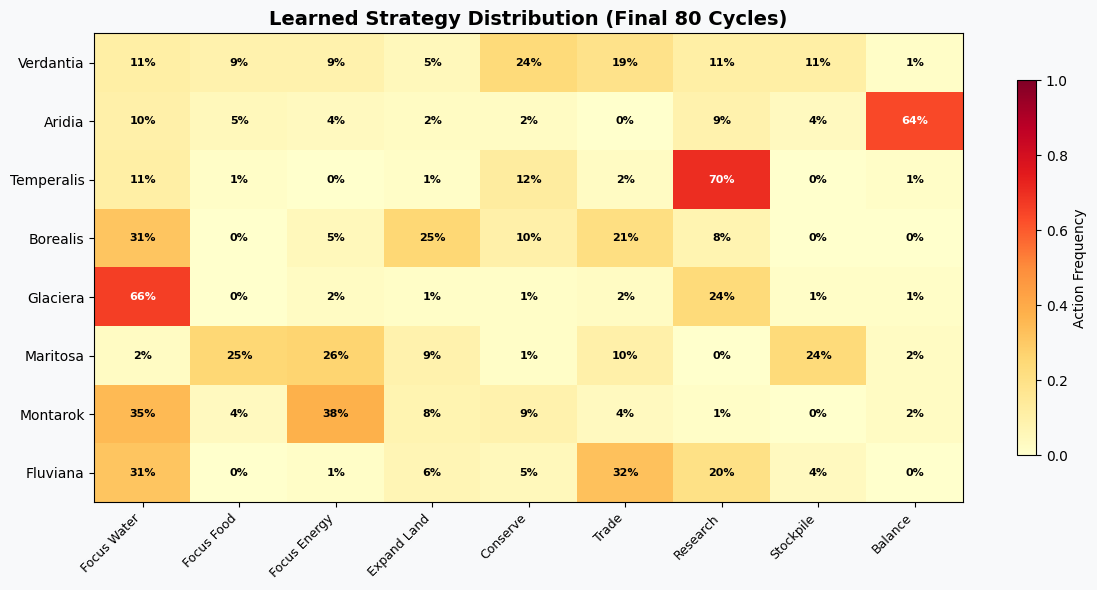

In [19]:
fig = plot_strategy_heatmap(agent_manager)
plt.show()

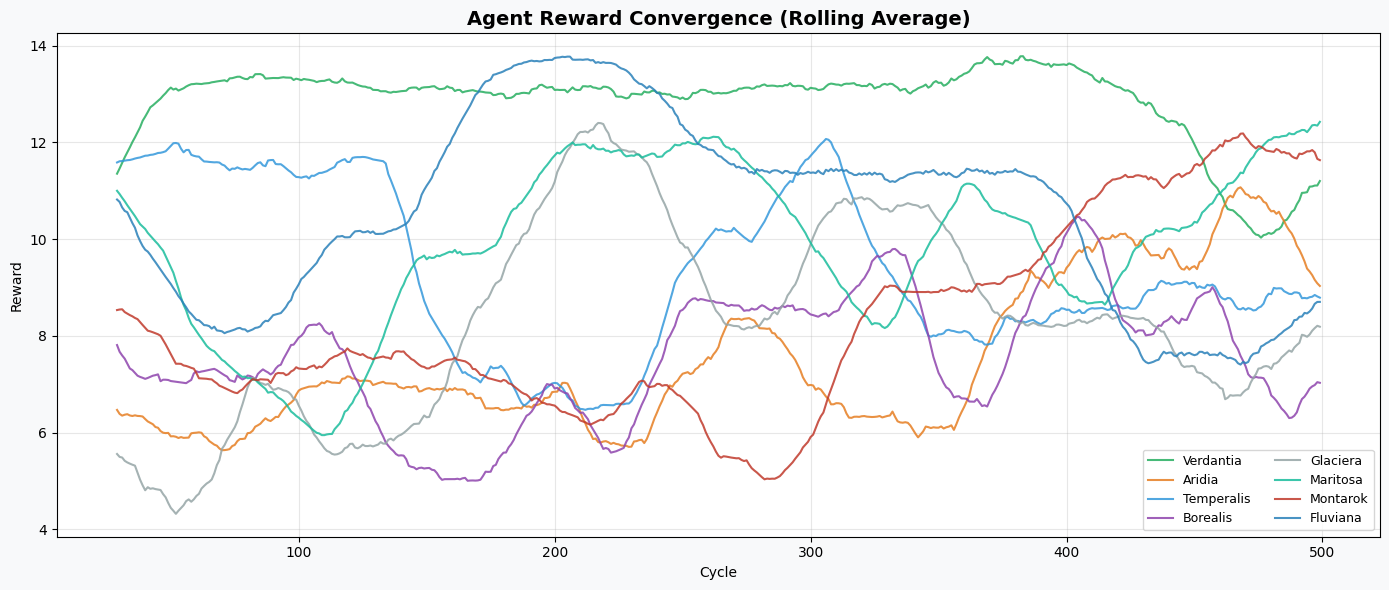

In [20]:
fig = plot_reward_curves(agent_manager)
plt.show()


🧠 Agent Learning Summary:
Agent          Total Reward  Avg R(50)       Strategy      ε  Q-States
--------------------------------------------------------------------
  Verdantia          6383.0      10.63       conserve 0.0500        32
  Aridia             3772.0      10.15        balance 0.0500        23
  Temperalis         4701.7       8.69       research 0.0500        54
  Borealis           3782.9       7.18    focus_water 0.0500        66
  Glaciera           4104.1       7.70    focus_water 0.0500        52
  Maritosa           4997.1      12.18   focus_energy 0.0500        42
  Montarok           4184.5      11.82   focus_energy 0.0500        40
  Fluviana           5262.1       8.17    focus_water 0.0500        37


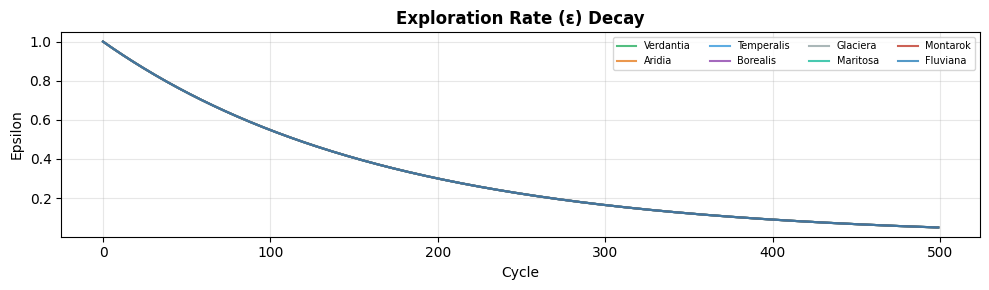

In [21]:
# Agent learning statistics
agent_summary = agent_manager.summary()

print("\n🧠 Agent Learning Summary:")
print(f"{'Agent':<14} {'Total Reward':>12} {'Avg R(50)':>10} {'Strategy':>14} {'ε':>6} {'Q-States':>9}")
print("-" * 68)
for name, info in agent_summary.items():
    print(f"  {name:<12} {info['total_reward']:>12.1f} {info['avg_reward_50']:>10.2f} "
          f"{info['dominant_strategy']:>14} {info['epsilon']:>6.4f} {info['q_table_states']:>9}")

# Epsilon decay visualization
fig, ax = plt.subplots(figsize=(10, 3))
for name, agent in agent_manager.agents.items():
    ax.plot(agent.epsilon_history, label=name, color=REGION_COLORS[name],
            linewidth=1.5, alpha=0.8)
ax.set_title('Exploration Rate (ε) Decay', fontsize=12, fontweight='bold')
ax.set_xlabel('Cycle')
ax.set_ylabel('Epsilon')
ax.legend(fontsize=7, ncol=4)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

---
## 8. Sustainability Analysis

Which strategies proved **sustainable**? Which regions **collapsed** and why? This section quantifies each region's performance across multiple dimensions.

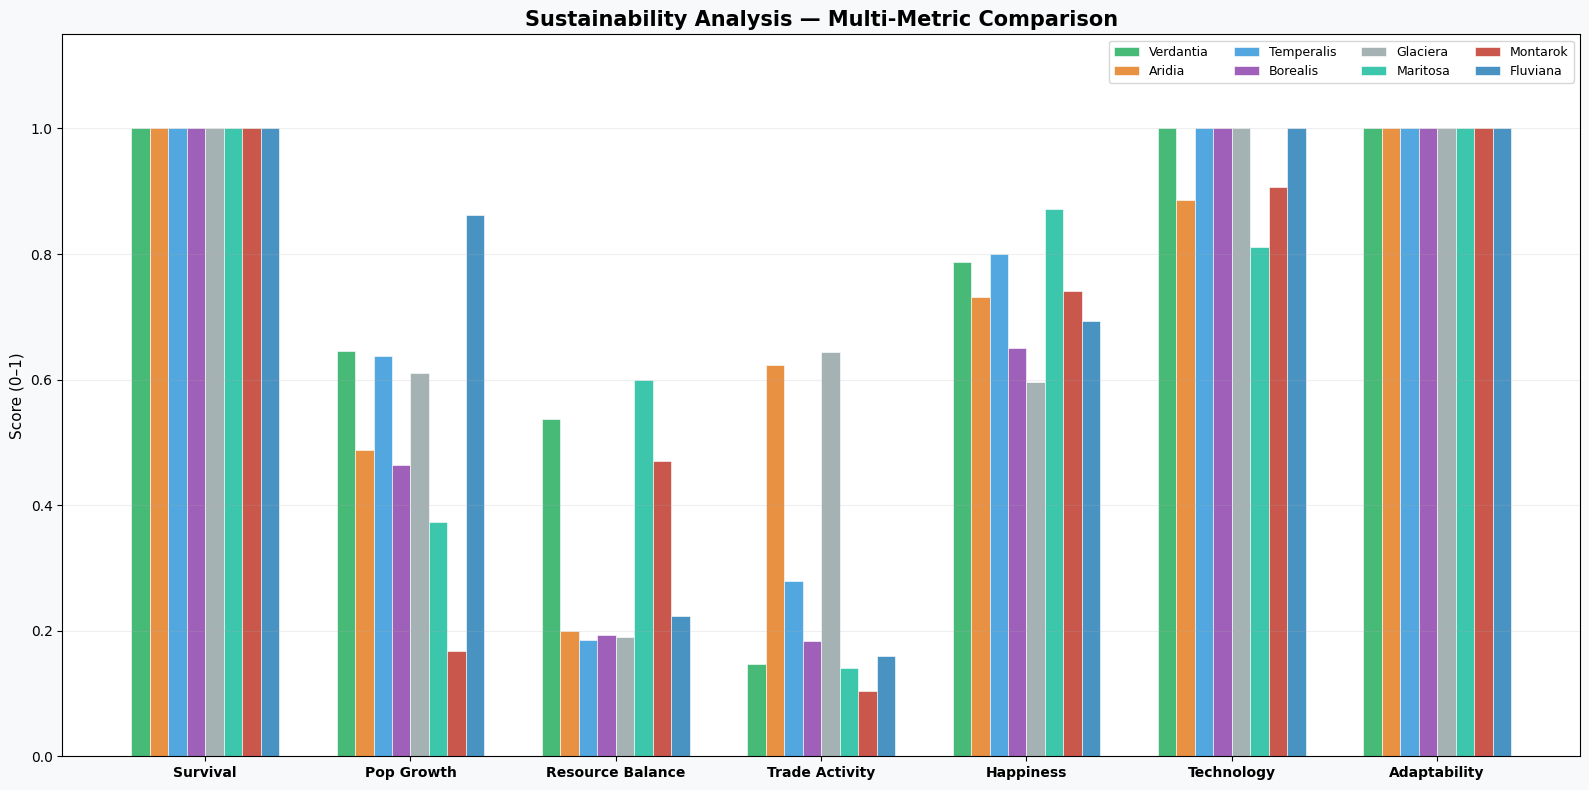

In [22]:
fig = plot_sustainability_analysis(world, agent_manager)
plt.show()

In [23]:
# ══════════════════════════════════════════════════════════
# DEEP ANALYSIS: WHY DID REGIONS SUCCEED OR FAIL?
# ══════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print(f"{'SUSTAINABILITY DEEP DIVE':^80}")
print("=" * 80)

n_cycles = len(world.population_history)

for name in world.get_region_names():
    region = world.regions[name]
    agent = agent_manager.agents[name]
    
    print(f"\n{'─'*60}")
    icon = BIOME_ICONS.get(region.biome.value, '🌍')
    status = '✓ SURVIVED' if region.is_alive else f'☠ COLLAPSED (cycle {region.collapse_cycle})'
    print(f"{icon} {name} — {region.biome.value} — {status}")
    print(f"{'─'*60}")
    
    # Population trajectory
    pop_start = world.population_history[0][name]
    pop_end = world.population_history[-1][name]
    pop_max = max(h[name] for h in world.population_history)
    pop_min = min(h[name] for h in world.population_history)
    print(f"  Population: {pop_start:.0f} → {pop_end:.0f} (peak: {pop_max:.0f}, trough: {pop_min:.0f})")
    
    # Resource trajectory
    for res in ['water', 'food', 'energy', 'land']:
        start_val = world.resource_history[0][name][res]
        end_val = world.resource_history[-1][name][res]
        min_val = min(h[name][res] for h in world.resource_history)
        min_cycle = [h[name][res] for h in world.resource_history].index(min_val) + 1
        trend = '📈' if end_val > start_val else '📉' if end_val < start_val * 0.8 else '➡️'
        print(f"  {trend} {res.capitalize():<8}: {start_val:.0f} → {end_val:.0f} (min: {min_val:.0f} at cycle {min_cycle})")
    
    # Dominant strategy
    strat = agent.strategy_distribution(last_n=100)
    top_strats = sorted(strat.items(), key=lambda x: -x[1])[:3]
    print(f"  Strategy mix (final 100 cycles):")
    for s, pct in top_strats:
        bar = '█' * int(pct * 30)
        print(f"    {s:<15} {bar} {pct:.0%}")
    
    # Events suffered
    region_events = [e for e in world.event_history 
                     if e['region'] == name or e.get('is_global')]
    neg_events = [e for e in region_events 
                  if e['type'].value not in ('bumper_harvest', 'energy_boom', 'water_discovery', 'technological_leap')]
    print(f"  Events: {len(region_events)} total ({len(neg_events)} negative)")
    
    # Trade participation
    trades = sum(1 for t in world.trade_system.trade_history 
                 if t['buyer'] == name or t['seller'] == name)
    print(f"  Trade participation: {trades} trades")
    print(f"  Final tech level: {region.tech_level:.2f}")
    print(f"  Total reward earned: {agent.total_reward:.0f}")

print(f"\n{'='*80}")


                            SUSTAINABILITY DEEP DIVE                            

────────────────────────────────────────────────────────────
🌴 Verdantia — Tropical Rainforest — ✓ SURVIVED
────────────────────────────────────────────────────────────
  Population: 120 → 155 (peak: 249, trough: 117)
  📈 Water   : 824 → 1024 (min: 451 at cycle 453)
  📈 Food    : 714 → 1053 (min: 714 at cycle 1)
  📈 Energy  : 264 → 365 (min: 242 at cycle 10)
  📈 Land    : 499 → 528 (min: 408 at cycle 247)
  Strategy mix (final 100 cycles):
    conserve        ██████ 20%
    stockpile       █████ 18%
    trade           ████ 16%
  Events: 189 total (137 negative)
  Trade participation: 44 trades
  Final tech level: 3.00
  Total reward earned: 6383

────────────────────────────────────────────────────────────
🏜️ Aridia — Arid Desert — ✓ SURVIVED
────────────────────────────────────────────────────────────
  Population: 80 → 78 (peak: 104, trough: 52)
  📉 Water   : 183 → 109 (min: 0 at cycle 210)
  📈 Food  

---
## 9. Interactive Dashboard (Plotly)

An interactive dashboard for exploring the simulation data. Hover over lines to see exact values, zoom into specific periods, and compare regions.

In [24]:
# Interactive Plotly dashboard
try:
    fig = plotly_resource_dashboard(world)
    if fig:
        fig.show()
    else:
        print("Plotly not available — static plots shown above.")
except Exception as e:
    print(f"Interactive dashboard unavailable: {e}")

---
## 10. Real-World Insights & Conclusions

What does this simulation reveal about real-world resource conflict dynamics?

In [25]:
# ══════════════════════════════════════════════════════════
# AUTOMATED INSIGHT GENERATION
# ══════════════════════════════════════════════════════════

print("\n" + "=" * 80)
print(f"{'🌍 WORLDSIM — EMERGENT INSIGHTS & REAL-WORLD PARALLELS':^80}")
print("=" * 80)

# Identify key patterns
survivors = [n for n, r in world.regions.items() if r.is_alive]
collapsed = [n for n, r in world.regions.items() if not r.is_alive]

# Strategy analysis
survivor_strategies = {}
collapsed_strategies = {}

for name in survivors:
    dom = agent_manager.agents[name].dominant_strategy(100)
    survivor_strategies[name] = dom

for name in collapsed:
    dom = agent_manager.agents[name].dominant_strategy(100)
    collapsed_strategies[name] = dom

print(f"\n📊 OUTCOME: {len(survivors)}/8 regions survived {NUM_CYCLES} cycles")
print(f"   Survivors: {', '.join(survivors)}")
if collapsed:
    print(f"   Collapsed: {', '.join(collapsed)}")

# Insight 1: Diversification vs Specialization
print("\n" + "-"*60)
print("🔑 INSIGHT 1: DIVERSIFICATION vs SPECIALISATION")
print("-"*60)
for name in survivors:
    dist = agent_manager.agents[name].strategy_distribution(100)
    entropy = -sum(p * np.log(p + 1e-10) for p in dist.values())
    max_action = max(dist, key=dist.get)
    max_pct = dist[max_action]
    style = "Diversified" if entropy > 1.5 else "Specialised" if max_pct > 0.4 else "Moderate"
    print(f"  {name:<14}: {style} (entropy={entropy:.2f}, top={max_action} at {max_pct:.0%})")
print("  → Real-world parallel: Nations with diversified economies tend to be")
print("    more resilient to external shocks than resource-dependent economies.")

# Insight 2: Trade as a survival mechanism
print("\n" + "-"*60)
print("🔑 INSIGHT 2: TRADE AS A SURVIVAL MECHANISM")
print("-"*60)
for name in world.get_region_names():
    trades = sum(1 for t in world.trade_system.trade_history 
                 if t['buyer'] == name or t['seller'] == name)
    status = '✓' if world.regions[name].is_alive else '☠'
    print(f"  {status} {name:<14}: {trades:>4} trades")
avg_survivor_trades = np.mean([sum(1 for t in world.trade_system.trade_history 
    if t['buyer'] == n or t['seller'] == n) for n in survivors]) if survivors else 0
avg_collapsed_trades = np.mean([sum(1 for t in world.trade_system.trade_history 
    if t['buyer'] == n or t['seller'] == n) for n in collapsed]) if collapsed else 0
print(f"  Average trades — Survivors: {avg_survivor_trades:.0f}, Collapsed: {avg_collapsed_trades:.0f}")
print("  → Real-world parallel: International trade creates mutual dependencies")
print("    that buffer against local resource shocks — but also vulnerability.")

# Insight 3: Climate vulnerability
print("\n" + "-"*60)
print("🔑 INSIGHT 3: UNEQUAL CLIMATE VULNERABILITY")
print("-"*60)
for name in world.get_region_names():
    neg_events = sum(1 for e in world.event_history 
                     if (e['region'] == name or e.get('is_global')) and
                     e['type'].value not in ('bumper_harvest', 'energy_boom', 
                                             'water_discovery', 'technological_leap'))
    biome = world.regions[name].biome.value
    status = '✓' if world.regions[name].is_alive else '☠'
    print(f"  {status} {name:<14} ({biome:<22}): {neg_events:>3} negative events")
print("  → Real-world parallel: Climate change disproportionately affects certain")
print("    geographies. Adaptation capacity depends on existing resources & tech.")

# Insight 4: Technology as a force multiplier
print("\n" + "-"*60)
print("🔑 INSIGHT 4: TECHNOLOGY AS A FORCE MULTIPLIER")
print("-"*60)
tech_pop = [(name, world.regions[name].tech_level, world.regions[name].population)
            for name in survivors]
tech_pop.sort(key=lambda x: -x[1])
for name, tech, pop in tech_pop:
    research_pct = agent_manager.agents[name].strategy_distribution(100).get('research', 0)
    print(f"  {name:<14}: Tech={tech:.2f}, Pop={pop:.0f}, Research={research_pct:.0%}")
print("  → Real-world parallel: R&D investment compounds over time, enabling")
print("    more efficient resource use and higher carrying capacity.")

# Insight 5: Emergent cooperation
print("\n" + "-"*60)
print("🔑 INSIGHT 5: EMERGENT COOPERATION WITHOUT CENTRAL AUTHORITY")
print("-"*60)
strong_pairs = [(k, v) for k, v in world.trade_system.relationship.items() if v > 0.65]
strong_pairs.sort(key=lambda x: -x[1])
if strong_pairs:
    print("  Strongest alliances (relationship > 0.65):")
    for (r1, r2), score in strong_pairs[:5]:
        print(f"    {r1} ↔ {r2}: {score:.2f}")
else:
    print("  No strong alliances formed — competitive dynamics dominated.")
print("  → Real-world parallel: Cooperation can emerge from self-interest when")
print("    trade creates positive-sum outcomes — mirroring game theory predictions.")

print("\n" + "=" * 80)
print("These emergent behaviours were NOT pre-programmed — they arose purely from")
print("agents maximising reward through interaction with the environment.")
print("=" * 80)


             🌍 WORLDSIM — EMERGENT INSIGHTS & REAL-WORLD PARALLELS              

📊 OUTCOME: 8/8 regions survived 500 cycles
   Survivors: Verdantia, Aridia, Temperalis, Borealis, Glaciera, Maritosa, Montarok, Fluviana

------------------------------------------------------------
🔑 INSIGHT 1: DIVERSIFICATION vs SPECIALISATION
------------------------------------------------------------
  Verdantia     : Diversified (entropy=2.03, top=conserve at 20%)
  Aridia        : Specialised (entropy=1.22, top=balance at 67%)
  Temperalis    : Specialised (entropy=1.00, top=research at 72%)
  Borealis      : Diversified (entropy=1.80, top=focus_water at 26%)
  Glaciera      : Specialised (entropy=0.96, top=focus_water at 71%)
  Maritosa      : Diversified (entropy=1.75, top=focus_food at 28%)
  Montarok      : Diversified (entropy=1.52, top=focus_energy at 38%)
  Fluviana      : Diversified (entropy=1.79, top=trade at 31%)
  → Real-world parallel: Nations with diversified economies tend to be
   

---
## 11. Multi-Seed Comparison (Robustness Check)

Run the simulation with different random seeds to verify that our findings are robust and not artifacts of a single random sequence.

In [26]:
# ══════════════════════════════════════════════════════════
# MULTI-SEED ROBUSTNESS ANALYSIS
# ══════════════════════════════════════════════════════════

N_SEEDS = 5
CYCLES_PER_SEED = 300

multi_results = []
print(f"Running {N_SEEDS} simulations with {CYCLES_PER_SEED} cycles each...\n")

for seed in range(N_SEEDS):
    w = World(seed=seed * 17 + 7, num_cycles=CYCLES_PER_SEED)
    am = AgentManager(w.get_region_names(), seed=seed * 17 + 7)
    
    for cycle in range(CYCLES_PER_SEED):
        prev = am.snapshot_states(w)
        decisions = am.get_decisions(w)
        w.step(decisions)
        am.update_all(w, prev)
    
    summary = w.get_summary()
    region_strats = {}
    for name in w.get_region_names():
        region_strats[name] = {
            'alive': w.regions[name].is_alive,
            'population': w.regions[name].population,
            'strategy': am.agents[name].dominant_strategy(80),
        }
    multi_results.append({'seed': seed, 'summary': summary, 'regions': region_strats})
    
    alive = len(summary['alive_regions'])
    pop = summary['total_population']
    print(f"  Seed {seed}: {alive}/8 survived, pop={pop:.0f}, trades={summary['total_trades']}")

# Survival rates across seeds
print(f"\n{'='*60}")
print(f"{'MULTI-SEED SURVIVAL ANALYSIS':^60}")
print(f"{'='*60}")

for name in world.get_region_names():
    survival_rate = np.mean([r['regions'][name]['alive'] for r in multi_results])
    avg_pop = np.mean([r['regions'][name]['population'] for r in multi_results])
    strategies = [r['regions'][name]['strategy'] for r in multi_results]
    most_common = max(set(strategies), key=strategies.count)
    bar = '█' * int(survival_rate * 20) + '░' * (20 - int(survival_rate * 20))
    print(f"  {name:<14} {bar} {survival_rate:.0%} survived | Avg Pop: {avg_pop:>6.0f} | Typical: {most_common}")

avg_survivors = np.mean([len(r['summary']['alive_regions']) for r in multi_results])
print(f"\nAverage survivors: {avg_survivors:.1f}/8 across {N_SEEDS} seeds")

Running 5 simulations with 300 cycles each...

  Seed 0: 8/8 survived, pop=763, trades=353
  Seed 1: 8/8 survived, pop=631, trades=304
  Seed 2: 8/8 survived, pop=586, trades=297
  Seed 3: 7/8 survived, pop=480, trades=271
  Seed 4: 8/8 survived, pop=671, trades=396

                MULTI-SEED SURVIVAL ANALYSIS                
  Verdantia      ████████████████████ 100% survived | Avg Pop:     51 | Typical: focus_energy
  Aridia         ████████████████████ 100% survived | Avg Pop:     84 | Typical: focus_water
  Temperalis     ████████████████████ 100% survived | Avg Pop:     76 | Typical: focus_energy
  Borealis       ████████████████░░░░ 80% survived | Avg Pop:     21 | Typical: conserve
  Glaciera       ████████████████████ 100% survived | Avg Pop:     48 | Typical: trade
  Maritosa       ████████████████████ 100% survived | Avg Pop:    120 | Typical: research
  Montarok       ████████████████████ 100% survived | Avg Pop:     25 | Typical: focus_energy
  Fluviana       █████████████

---
## 12. Final World Map

The final state of the world after the simulation — showing surviving regions, their relative sizes (population), trade connections, and resource levels.

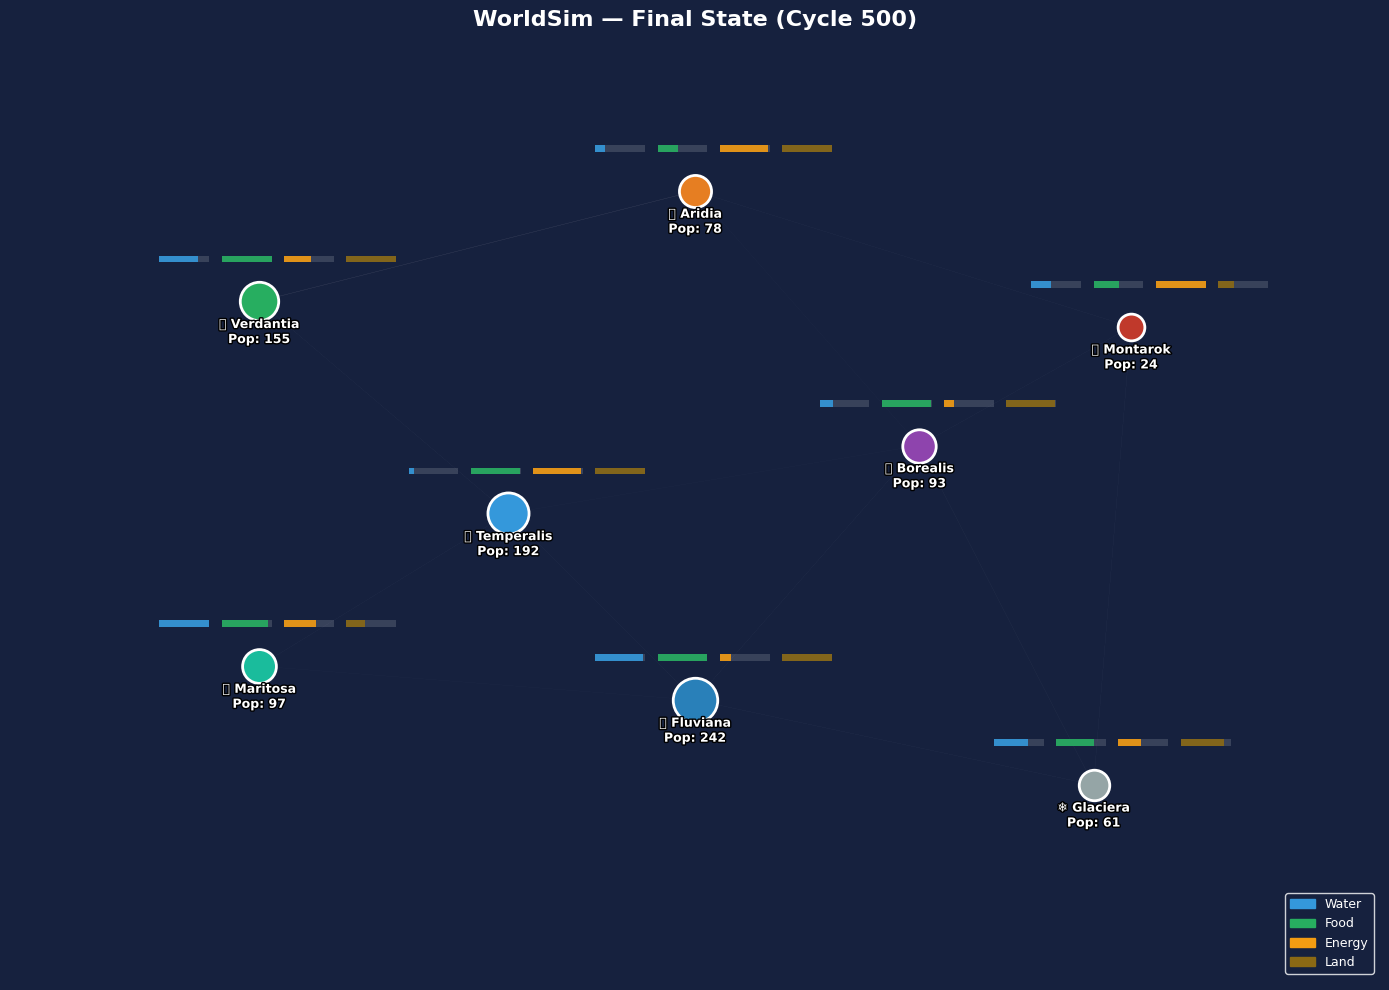

In [27]:
fig = plot_world_map(world, title=f"WorldSim — Final State (Cycle {world.cycle})")
plt.show()

---

## Summary

### Key Takeaways from WorldSim

1. **Emergent Cooperation**: Agents discover trade as beneficial without being told — mirroring how real-world trade agreements form from mutual interest.

2. **Climate Vulnerability is Unequal**: Regions with natural resource scarcity (Aridia, Glaciera) face compounding crises from climate events, reflecting the real-world "climate justice" challenge.

3. **Diversification Wins**: Agents that learn balanced strategies with trade engagement outperform pure specialists, paralleling how diversified economies are more resilient.

4. **Technology Compounds**: Small consistent investment in research leads to dramatic long-term advantages through improved production efficiency.

5. **Collapse is Non-Linear**: Regions don't decline gradually — they appear stable until a critical threshold, then collapse rapidly ("Seneca cliff" pattern seen in real civilisations).

6. **Relationships Matter**: Trade relationships that are built during prosperous times provide crucial support during crises — social capital as a buffer.

### Technical Architecture
- **Engine**: Custom event-driven simulation with 8 biome-typed regions
- **AI**: Tabular Q-learning with ε-greedy exploration (no GPU required)
- **State Space**: ~5,000 discrete states per agent (resource levels + population + happiness)
- **Action Space**: 9 strategic actions per agent per cycle
- **Trade System**: Bilateral surplus/deficit matching with evolving relationship scores
- **Climate**: Biome-weighted event generation with seasonal & long-term stress factors
- **Optimised**: Runs in <30s on Intel i5-1220P (CPU-only)

---
*WorldSim — Sitnovate 2026 Hackathon Project*